In [1]:
import numpy as np
import seaborn as sns
from pyffo import pyfferaph as pf
from pyffo import filter_piff as pyff 
import MDAnalysis as mda
import pandas as pd
import multiprocessing

# The user has to modify the cell below

All the input files and selection are specifies using dictionries 

**data_dict** contains the trajctory and topology files 

**analysis_dict** contains the N residues for which the interaction networks (N x N matrices) will be computed

**salt_dict** contains the selection for the salt bridge interactions, the deafult distance is set to 4.5 A and the output name for the interaction file 

**hc_dict** contains the selection for the hydrophbic interactions, the deafult distance is set to 5 A and the output name for the interaction file 

**hb_dict** contains the selection for the hydrogen bonds, the deafult distance is set to 3.5 A, the Donor-H-Acceptor angle to 120° and the output name for the interaction file. Since this function can on more than one more than one core he number of cores is specified here, 0 means that pyfferaph will make use of all the available cores

In [2]:
# Input
data_dict = dict(pdb='example_trajs/sim.prot.A.pdb',
                 traj='example_trajs/traj.xtc',
                 top='example_trajs/sim_protA.tpr'
                 )

# Analysis dict:

# Common data: the argument `system` is required to create the proper
# matrix. Use "protein or resname DGPS" if you want include DGPS lipids
analysis_dict = dict(system="protein",
                     start = 0,
                     stop = None, 
                     stride = 1
                    )

# Salt bridge selection. To include lipids, modify `sel_basic` and `sel_acidic` accordingly.
sb_dict = dict(sb_file="example_matrices/my_sb.dat",
               sel_basic="(resname LYS and name CE NZ HZ*) or (resname ARG and name CD NE CZ NH1 NH2 HH11 HH12 HH21 HH22)",
               sel_acidic="(resname ASP and name CG OD1 OD2) or (resname GLU and name CD OE1 OE2)",
               sb_dist=4.5,
               # Define if there are charged cter, nter and protonated his
               cter_sel="(resid 148 and name C OT1 OT2)",
               nter_sel="",
               histidine_sel=""
              )

# The hydrophobic contacts
hc_dict = dict(hc_file="example_matrices/my_hc.dat",
               hydrophobic_sel="resname ALA ILE VAL LEU PHE MET TRP PRO", 
               backbone_sel="name N H HN CA HA C O OT1 OT2 HT2",
               hc_cutoff=5.
)

# Hydrogen bond selections. To include other molecule, modify acceptor and donor selections accordingly
# 
#NB: ncores defines the number of cores to run the hb analysis in parallel, ncores=0 means all the available cores.
hb_dict = dict(hb_file="example_matrices/my_hb.dat",
               tmp_csv="tmp_file_hbonds",
               acceptors="protein and name OH OG OD1 OD2 OG1 O ND1 NE2 OE2 OW SG OE1 OH2 SD",
               donors="protein and name OH OG NE2 OG1 NE N ND1 NZ NH1 NH2 OW ND2 SG OH2 NE1",
               d_a_dist=3.5,
               angle=120,
               update_sel=False,
               ncores=1
)



# Salt bridges 

<AxesSubplot:>

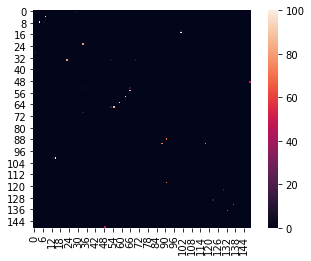

In [3]:
sb = pf.SaltBridges(input_dict=data_dict, 
                   analysis_dict=analysis_dict, 
                   sb_dict=sb_dict)

sb_network = sb.run()

sns.heatmap(sb_network, square=True)

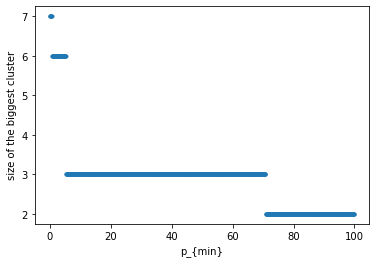

In [4]:
sb_matrix = np.loadtxt("example_matrices/my_sb.dat")
pyff.cluster_plotter(sb_matrix, 'sb_cluster.pdf')

# Hydrophobic contacts

<AxesSubplot:>

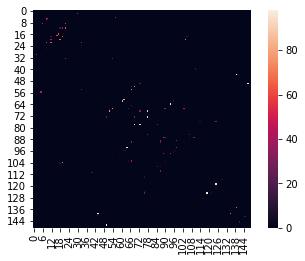

In [5]:
hc = pf.HydrophobicInteractions(input_dict=data_dict, 
                   analysis_dict=analysis_dict, 
                   hc_dict=hc_dict)

hc_network = hc.run()

sns.heatmap(hc_network, square=True)

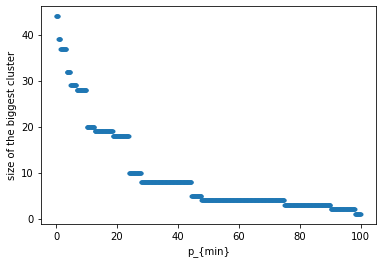

In [6]:
hc_matrix = np.loadtxt("example_matrices/my_hc.dat")
pyff.cluster_plotter(hc_matrix, 'hc_cluster.pdf')

# Hydrogen bonds

In [7]:
u = mda.Universe(data_dict['top'], data_dict['traj'], in_memory=True)

# Need to know the number of entry to initialise the matrix
sel = u.select_atoms(analysis_dict['system'])
residxs = np.unique(sel.resindices)
nres = len(residxs)

# Need to know the number of frames to run in parallel
if analysis_dict['stop'] == None:
    nframes = (u.trajectory.n_frames - analysis_dict['start']) // analysis_dict['stride']
else:
    nframes = (analysis_dict['stop'] - analysis_dict['start']) // analysis_dict['stride']


In [8]:
pf.HBondInteraction(data_dict['top'], data_dict['traj'], 
                 donor_sel=hb_dict['donors'], 
                 acceptor_sel=hb_dict['acceptors'], 
                 nframe=nframes, output_csv=hb_dict['tmp_csv'], ncores=hb_dict['ncores'])

Using 1
THe intervals are: [(0, None)]
Pooling with 1 core(s)...


In [9]:
merged_df = pf.MergingHBDataframe(hb_dict['tmp_csv'], nframe=nframes, ncores=hb_dict['ncores'])

Using 1


In [10]:
pf.HBMatrix(u=u, nres=nres, nframes=nframes, hb_df=merged_df, 
         stride=analysis_dict['stride'], hb_file=hb_dict['hb_file'])

<AxesSubplot:>

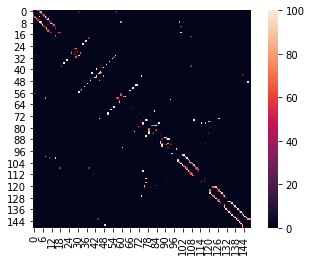

In [11]:
hb_matrix = np.loadtxt(hb_dict['hb_file'])
sns.heatmap(hb_matrix, square=True)

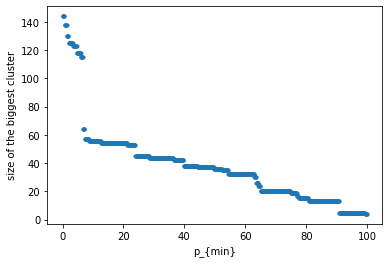

In [12]:
pyff.cluster_plotter(hb_matrix, 'hb_cluster.pdf')

# PSN

In [13]:
macro_inn = pyff.macroINN_generator([hc_matrix, sb_matrix, hb_matrix], 20)

final_network = pyff.network_generator(macro_inn, 'example_trajs/sim.prot.A.pdb')

print(final_network.nodes)

['SER2', 'ARG3', 'ALA4', 'LYS5', 'ARG6', 'ILE7', 'MET8', 'LYS9', 'GLU10', 'ILE11', 'GLN12', 'ALA13', 'VAL14', 'LYS15', 'ASP16', 'ASP17', 'PRO18', 'ALA19', 'ALA20', 'HIS21', 'ILE22', 'THR23', 'LEU24', 'GLU25', 'PHE26', 'VAL27', 'SER28', 'GLU29', 'SER30', 'ASP31', 'ILE32', 'HIS33', 'HIS34', 'LEU35', 'LYS36', 'GLY37', 'THR38', 'PHE39', 'LEU40', 'GLY41', 'PRO42', 'PRO43', 'GLY44', 'THR45', 'PRO46', 'TYR47', 'GLU48', 'GLY49', 'GLY50', 'LYS51', 'PHE52', 'VAL53', 'VAL54', 'ASP55', 'ILE56', 'GLU57', 'VAL58', 'PRO59', 'MET60', 'GLU61', 'TYR62', 'PRO63', 'PHE64', 'LYS65', 'PRO66', 'PRO67', 'LYS68', 'MET69', 'GLN70', 'PHE71', 'ASP72', 'THR73', 'LYS74', 'VAL75', 'TYR76', 'HIS77', 'PRO78', 'ASN79', 'ILE80', 'SER81', 'SER82', 'VAL83', 'THR84', 'GLY85', 'ALA86', 'ILE87', 'CYS88', 'LEU89', 'ASP90', 'ILE91', 'LEU92', 'LYS93', 'ASN94', 'ALA95', 'TRP96', 'SER97', 'PRO98', 'VAL99', 'ILE100', 'THR101', 'LEU102', 'LYS103', 'SER104', 'ALA105', 'LEU106', 'ILE107', 'SER108', 'LEU109', 'GLN110', 'ALA111', 'LEU1

/Users/alberto/miniconda3/envs/pyffe/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:330: UserWarning: Element information is absent or missing for a few atoms. Elements attributes will not be populated.
  warnings.warn("Element information is absent or missing for a few "


In [14]:
from pyffo import filter_piff as pyff 


pyff.all_shortest_path(final_network, 'SER2',  'SER150', 20, terminal=False)

In [15]:
pyff.selective_betweenness(final_network, 'SER2',  'SER150', 'SER2')

source: SER2 target: SER150
selective betweenness for SER2: 1.0


1.0

In [16]:
pyff.paths_to_interface(final_network, ['SER2'],  ['SER150'], 20)

0 paths written to SER2.dat
